In [1]:
%matplotlib inline
# common functions used in the project of VR-R in GAC direction
import numpy as np
#import scipy.linalg as splin
import numpy.linalg as nl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
font = {'size' : 20}
matplotlib.rc('font', **font)
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.special as special
import astropy.io.fits as fits
import math as m
import emcee
import corner
import pandas as pd
import csv
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import sys
sys.path.append('/Users/htian/Documents/GitHub/astroth/')
import CoordinateConversion as CC
import galpy.util.bovy_coords as gub
import sfdmap


In [2]:
def rmrotpm(ra,dec,pmra,pmdec):
    cwx = -0.086
    cwy = -0.114
    cwz = -0.037
    cpmra = pmra+cwx*np.sin(dec*m.pi/180)*np.cos(ra*m.pi/180)  \
                +cwy*np.sin(dec*m.pi/180)*np.sin(ra*m.pi/180)  \
                -cwz*np.cos(dec*m.pi/180)  
    cpmdec = pmdec-cwx*np.sin(ra*m.pi/180) + cwy*np.cos(ra*m.pi/180)
    pmradec = np.zeros((len(ra),2))
    pmradec[:,0] = cpmra
    pmradec[:,1] = cpmdec 
    return pmradec

In [3]:
# dpath = "/Users/htian/Documents/work/data/Gaia_Mgiant_candidate/"
dpath = ""
# ppath = "/Users/htian/Documents/work/plots/Gaia_Mgiant_candidate/"
ppath = ""
fn = "GDR2_Mgiant_candidate_color2_b20_gmag10_20_rest_4000_EBV.fits"
# fn = "Gaia_XMTACH_LiJ_MG.fits"

In [4]:
bet_lim = 30
fig_fmt= ".png"
U_sun, V_sun, W_sun = 11.1, 12.24, 7.25
X_sun = 8.3
V_LSR = 232#232#218#232

In [5]:
print(np.arctan2(1,0)*180/m.pi)

90.0


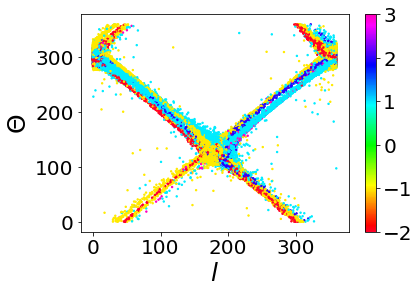

In [6]:
dataLM = np.loadtxt("SgrTriax_DYN.dat",skiprows=1)
raLM,decLM = dataLM[:,2],dataLM[:,3]
llLM,bbLM = dataLM[:,4],dataLM[:,5]
LamLM0,BetLM0 = dataLM[:,0],dataLM[:,1]
pmllLM,pmbbLM = dataLM[:,20],dataLM[:,21]
distLM = dataLM[:,18]
thetaLM = np.arctan2(pmllLM,pmbbLM)*180/m.pi
thetaLM = (thetaLM+360) % 360
LABELM = CC.radec2sag(raLM,decLM)
LamLM = LABELM[:,0]
LamLM = (LamLM+360) % 360
BetLM = LABELM[:,1]
Pcol = dataLM[:,-2]
LMflag = dataLM[:,-1]
ind_LM = np.abs(LMflag)==1
fig = plt.figure(figsize=(6,4))
# plt.plot(llLM,thetaLM,'k.',markersize=1,alpha=0.3)
# plt.plot(llLM[ind_LM],thetaLM[ind_LM],'r.',markersize=1)
plt.scatter(llLM,thetaLM,s=2,c=LMflag,cmap='gist_rainbow')
# plt.scatter(llLM,thetaLM+360,s=5,c=LMflag,cmap='gist_rainbow')
# plt.scatter(llLM+360,thetaLM,s=5,c=LMflag,cmap='gist_rainbow')
# plt.scatter(llLM+360,thetaLM+360,s=5,c=LMflag,cmap='gist_rainbow')
plt.xlabel("$l$",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.colorbar()

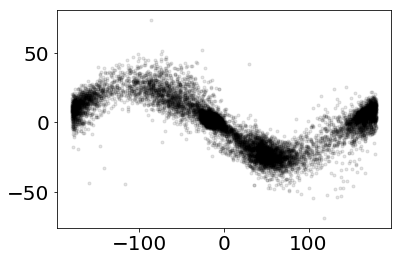

In [7]:
dataDM = np.loadtxt("285_stars_stripping_data.csv",skiprows=1,delimiter=',')
raDM, decDM = dataDM[:,3],dataDM[:,4]
vlosDM,distDM = dataDM[:,5],dataDM[:,6]
sag_coo_DM = CC.radec2sag(raDM,decDM)
LamDM, BetDM = sag_coo_DM[:,0],sag_coo_DM[:,1]
plt.plot(LamDM,BetDM,'k.',alpha=0.1)
# plt.axis([50,60,200,300])

43.650806
265.03242
43.650806
[-3.15208351 -2.85452492 -2.56134527]
[-0.29755859  0.          0.29317965] -2.85452492167
-2.87546057112 0.441279489588
[-2.74061591  0.          2.70028437]


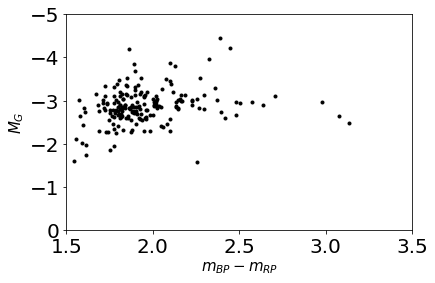

In [11]:
#  to obtain the relation between Bp-Rp versus the absolute magnitude MG
dtM = fits.open("sgr_dr4_candidates_197_XMATCH_LDR5_GDR2.fits")
dataM = dtM[1].data
raM = dataM["ra_epoch2000"]
decM = dataM["dec_epoch2000"]
BPRPM = dataM["bp_rp"]
distM = dataM["sgr_dr4.dist"]
MagGM = dataM["phot_g_mean_mag"]
ind = BPRPM == BPRPM
print(distM[0])
raM = raM[ind]
decM = decM[ind]
BPRPM = BPRPM[ind]
distM = distM[ind]
MagGM = MagGM[ind]
print(np.max(distM))
print(distM[0])

dmap=sfdmap.SFDMap('/Users/htian/Documents/GitHub/sfddata-master',scaling=1.0)
ebv_M = dmap.ebv(raM,decM)
AmG_M = 2.35*ebv_M
AmBp_M = 3.11*ebv_M
AmRp_M = 1.829*ebv_M
ABS_MagGM = MagGM - AmG_M - 5*np.log10(distM*100)
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0.15,0.2,0.8,0.75])
plt.plot(BPRPM-AmBp_M+AmRp_M,ABS_MagGM,'k.')
plt.axis([1.5,3.5,0,-5])
plt.xlabel("$m_{BP}-m_{RP}$",fontsize=15)
plt.ylabel("$M_G$",fontsize=15)
fig.savefig(ppath+"CMD_knowndist.pdf")
# print((BPRPM>1.5))
perM=np.percentile(ABS_MagGM[:],(16,50,84))
# perM=np.percentile(ABS_MagGM[BPRPM>1.5],(16,50,84))
print(perM)
print(perM-perM[1],perM[1])
print(np.mean(ABS_MagGM[BPRPM>1.5]),np.std(ABS_MagGM[BPRPM>1.5]))
print(np.log(10)*(perM-perM[1])/5*20)

In [ ]:
# load simulated data
dtS = fits.open(dpath+"Mock_GDR2_Mgiant_candidate_color2_b20_gmag10_20_rest_4000.fits")
dataS = dtS[1].data
distS = 1/dataS["parallax"]
raS = dataS["ra"]
decS = dataS["dec"]
pmraS = dataS["pmra"]
pmdecS = dataS["pmdec"]
rvS = dataS["radial_velocity"]
llbb_S = gub.radec_to_lb(raS,decS,degree=True)
sag_coo_S = CC.radec2sag(raS,decS)
LamS = (sag_coo_S[:,0]+360) % 360
BetS = sag_coo_S[:,1]
pmllbbS = gub.pmrapmdec_to_pmllpmbb(pmraS,pmdecS,raS,decS)
theta_pmS = np.arctan2(pmllbbS[:,0],pmllbbS[:,1])*180/m.pi
theta_pmS = (theta_pmS+360)%360
indS = (np.abs(BetS)<bet_lim) #& (distS<150)  & (distS>10)

fig = plt.figure(figsize=(15,12))
ax = fig.add_axes([0.1,0.1,0.85,0.85])

plt.scatter(llbb_S[indS,0],theta_pmS[indS],s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(llbb_S[indS,0]+360,theta_pmS[indS],s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(llbb_S[indS,0],theta_pmS[indS]+360,s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(llbb_S[indS,0]+360,theta_pmS[indS]+360,s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
# plt.plot(sag_c_coo[0,0]+360,theta_pm_sag,'ko',markersize=15)
# plt.plot(sag_c_coo[0,0],theta_pm_sag,'ko',markersize=15)
# plt.plot(sag_c_coo[0,0]+360,theta_pm_sag+360,'ko',markersize=15)
# plt.plot(sag_c_coo[0,0],theta_pm_sag+360,'ko',markersize=15)
plt.colorbar()
plt.axis([0,360,0,360])
plt.xlabel("$l$(degree)",fontsize=30)
plt.ylabel("$\Theta$(degree)",fontsize=30)
plt.savefig(ppath+"Mock_L_The.png")


fig = plt.figure(figsize=(15,12))
ax = fig.add_axes([0.1,0.1,0.85,0.85])

plt.scatter(LamS[indS],theta_pmS[indS],s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(LamS[indS]+360,theta_pmS[indS],s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(LamS[indS],theta_pmS[indS]+360,s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(LamS[indS]+360,theta_pmS[indS]+360,s=20,c = distS[indS],cmap='gist_rainbow',vmin=20,vmax=80)
# plt.plot(sag_c_coo[0,0]+360,theta_pm_sag,'ko',markersize=15)
# plt.plot(sag_c_coo[0,0],theta_pm_sag,'ko',markersize=15)
# plt.plot(sag_c_coo[0,0]+360,theta_pm_sag+360,'ko',markersize=15)
# plt.plot(sag_c_coo[0,0],theta_pm_sag+360,'ko',markersize=15)
# plt.colorbar()
plt.axis([0,360,0,360])
plt.xlabel("$\\tilde\Lambda_{\odot}$(degree)",fontsize=30)
plt.ylabel("$\Theta$(degree)",fontsize=30)
plt.savefig(ppath+"Mock_Lam_The.png")

In [ ]:
dt = fits.open(dpath+fn)
data = dt[1].data

In [ ]:
raGa = np.array(data["ra"])
decGa = np.array(data["dec"])
pmraGa = np.array(data["pmra"])
pmdecGa = np.array(data["pmdec"])
pmraGea = np.array(data["pmra_error"])
pmdecGea = np.array(data["pmdec_error"])
MagGa = np.array(data["phot_g_mean_mag"])
lGa = np.array(data["l"])
bGa = np.array(data["b"])
S_IDa = data["source_id_1"]
AENa = data["astrometric_excess_noise"]
BEFa = data["phot_bp_rp_excess_factor"] 
EBVa = data["EBV"]
rvGa = data["radial_velocity"]
rveGa = data["radial_velocity_error"]
ind = (AENa<0.25) & (BEFa<1.5) & (EBVa<0.8)
raG = raGa[ind]
decG = decGa[ind]
pmraG = pmraGa[ind]
pmdecG = pmdecGa[ind]
pmraGe = pmraGea[ind]
pmdecGe = pmdecGea[ind]
MagG = MagGa[ind]
lG = lGa[ind]
bG = bGa[ind]
S_ID = S_IDa[ind]
AEN = AENa[ind]
BEF = BEFa[ind]
EBV = EBVa[ind]
rv = rvGa[ind]
rve = rveGa[ind]
print(len(EBV))

sag_coo = CC.radec2sag(raG,decG)
csag_coo = CC.radec2sag(np.array([266]),np.array([-30]))
sag_c_coo = CC.radec2sag(np.array([283.8313]),np.array([-30.5453]))
lb_sag = gub.radec_to_lb(np.array([283.8313]),np.array([-30.5453]),degree=True)
Lam = sag_coo[:,0]
Lam = (Lam+360) % 360
Bet = sag_coo[:,1]
pmllbb = gub.pmrapmdec_to_pmllpmbb(pmraG,pmdecG,raG,decG,degree=True)

dmap=sfdmap.SFDMap('/Users/htian/Documents/GitHub/sfddata-master',scaling=1.0)
ebv = dmap.ebv(raG,decG)
AmG = 2.35 * ebv * 0.86
C_LMC = [78.77, -69.01]
C_SMC = [16.26, -72.42]
D2LMC = np.sqrt((raG-C_LMC[0])**2*np.cos(C_LMC[1]*m.pi/180)**2 + (decG-C_LMC[1])**2)
D2SMC = np.sqrt((raG-C_SMC[0])**2*np.cos(C_SMC[1]*m.pi/180)**2 + (decG-C_SMC[1])**2)
R_LMC, R_SMC = 13,8

Ds = 10**((MagG-AmG-perM[1])/5)/100
Dsag = np.sqrt(25.2**2+2.5**2+6.4**2)
lb_sag = gub.radec_to_lb(np.array([283.8313]),np.array([-30.5453]),degree=True)
pmra_sag,pmdec_sag = -2.692,-1.359
pmlb_sag = gub.pmrapmdec_to_pmllpmbb(-2.692,-1.359,283.8313,-30.5453,degree=True)
print(np.max(Ds),Dsag)

xyz = gub.lbd_to_XYZ(lG,bG,Ds,degree=True)  
xyzsag = gub.lbd_to_XYZ(Lam,Bet,Ds,degree=True)  

# col1 = fits.Column(name='source_id',format='K',array=S_ID)
# col2 = fits.Column(name='EBV',format='E',array=ebv)
# cols = fits.ColDefs([col1, col2])
# hdu = fits.BinTableHDU.from_columns(cols)
# hdu.writeto(dpath+'GaiaDR2Mgiant_EBV.fits',overwrite=True)
# outputebv = np.zeros((len(ebv),2))
ind_sag = (np.abs(Bet)<bet_lim)  & (D2LMC>R_LMC) & (D2SMC>R_SMC) & (MagG<19)#\
          # & (Ds<150) & (Ds>10) & (np.sqrt((pmraG+1)**2+(pmdecG+1.5)**2)<3)
ind_sag0 = (np.abs(Bet)<bet_lim)  & (D2LMC>R_LMC) & (D2SMC>R_SMC) \
          & (np.sqrt((pmraG+1)**2+(pmdecG+1.5)**2)<3)

theta_pm = np.arctan2(pmllbb[ind_sag,0],pmllbb[ind_sag,1])*180/m.pi
theta_pma = np.arctan2(pmllbb[:,0],pmllbb[:,1])*180/m.pi
theta_pm_sag = np.arctan2(pmlb_sag[0],pmlb_sag[1])*180/m.pi
theta_pm = (theta_pm+360)%360
theta_pma = (theta_pma+360)%360
theta_pm_sag = (theta_pm_sag+360)%360

In [ ]:
ind_LMC = D2LMC<R_LMC
ind_SMC = D2SMC<R_SMC
fig = plt.figure(figsize=(20,8))
# plt.plot(Lam,Bet,'k.',markersize=1)
# plt.plot(Lam+360,Bet,'k.',markersize=1)
# indd = (Ds>20) & (Ds<120) #& (D2LMC>R_LMC) & (D2SMC>R_SMC)
# plt.plot(Lam,Bet,'k.',markersize=0.3)
# plt.plot(Lam+360,Bet,'k.',markersize=0.3)
plt.scatter(Lam,Bet,s=5,c = Ds,cmap='gist_rainbow',vmin = 20,vmax=50)
# plt.scatter(Lam+360,Bet,s=5,c = Ds,cmap='gist_rainbow',vmin = 20,vmax=50)
# plt.plot(Lam[ind_LMC],Bet[ind_LMC],'r.',markersize=1)
# plt.plot(Lam[ind_LMC]+360,Bet[ind_LMC],'r.',markersize=1)
# plt.plot(Lam[ind_SMC],Bet[ind_SMC],'b.',markersize=1)
# plt.plot(Lam[ind_SMC]+360,Bet[ind_SMC],'b.',markersize=1)
plt.plot(csag_coo[0,0],csag_coo[0,1],'go',markersize=15)
# plt.plot(csag_coo[0,0]+360,csag_coo[0,1],'go',markersize=15)
# plt.plot(sag_c_coo[0,0],sag_c_coo[0,1],'ko',markersize=15)
# plt.plot([-180,780],[23,23])
# plt.plot([-180,780],[15,15])
plt.plot([-180,780],[bet_lim,bet_lim],'k--')
plt.plot([-180,780],[-bet_lim,-bet_lim],'k--')
plt.axis([0,360,-90,90])
plt.xlabel("$\\tilde\Lambda_{\odot}$(degree)",fontsize=25)
plt.ylabel("$B$(degree)",fontsize=25)
plt.colorbar()
plt.savefig(ppath+"Lam_Bet_sample.png")
plt.show()
print(csag_coo)

In [ ]:
pmlb_sag

In [ ]:
plt.plot(Ds,np.sqrt(pmraG**2+pmdecG**2),'k.',alpha=0.2)
plt.axis([0,150,0,30])

In [ ]:
fig = plt.figure(figsize=(10,8))
# plt.plot(Lam,Ds,'k.',alpha=0.1)
# plt.plot(Lam+360,Ds,'k.',alpha=0.1)
ind_p = Pcol<=30
plt.plot(LamLM[ind_p],distLM[ind_p],'k.',markersize=0.5,alpha=0.5)
plt.plot(LamLM[ind_p]-360,distLM[ind_p],'k.',markersize=0.5,alpha=0.5)
plt.plot(Lam[ind_sag],Ds[ind_sag],'r.')
plt.plot(Lam[ind_sag]-360,Ds[ind_sag],'r.')
# plt.plot(Lam,Ds,'r.')
# plt.plot(Lam-360,Ds,'r.')
# plt.scatter(Lam[ind_sag],Ds[ind_sag],c=Bet[ind_sag],s=15,cmap='gist_rainbow',vmin=-10,vmax=10)
# plt.scatter(Lam[ind_sag]+360,Ds[ind_sag],c=Bet[ind_sag],s=15,cmap='gist_rainbow',vmin=-10,vmax=10)
# plt.colorbar()
plt.plot(sag_c_coo[0,0],[Dsag],'go',markersize=15)
plt.plot(sag_c_coo[0,0]-360,[Dsag],'go',markersize=15)
plt.axis([-180,180,0,100])
plt.xlabel("$\\tilde{\Lambda}_\odot$",fontsize=20)
plt.ylabel("$D$(kpc)",fontsize=20)
plt.savefig(ppath+"Lam_DLM.png")
plt.show()
# ind_sag1 = (D2LMC>R_LMC) & (D2SMC>R_SMC) & (np.abs(bG)>30)
# fig = plt.figure(figsize=(10,4))
# plt.plot(Lam[ind_sag1],Ds[ind_sag1],'k.')
# plt.axis([0,360,10,80])
fig = plt.figure(figsize=(10,8))
# plt.plot(Lam,Ds,'k.',alpha=0.1)
# plt.plot(Lam+360,Ds,'k.',alpha=0.1)
plt.plot(LamDM,distDM,'k.',markersize=2,alpha=0.5)
plt.plot(LamDM-360,distDM,'k.',markersize=2,alpha=0.5)
plt.plot(Lam[ind_sag],Ds[ind_sag],'r.')
plt.plot(Lam[ind_sag]-360,Ds[ind_sag],'r.')
# plt.scatter(Lam[ind_sag],Ds[ind_sag],c=Bet[ind_sag],s=15,cmap='gist_rainbow',vmin=-10,vmax=10)
# plt.scatter(Lam[ind_sag]+360,Ds[ind_sag],c=Bet[ind_sag],s=15,cmap='gist_rainbow',vmin=-10,vmax=10)
# plt.colorbar()
plt.plot(sag_c_coo[0,0],[Dsag],'go',markersize=15)
plt.plot(sag_c_coo[0,0]-360,[Dsag],'go',markersize=15)
plt.axis([-180,180,0,100])
plt.xlabel("$\\tilde{\Lambda}_\odot$",fontsize=20)
plt.ylabel("$D$(kpc)",fontsize=20)
plt.savefig(ppath+"Lam_D_DM.png")
plt.show()

In [ ]:
sxx = np.linspace(0,180,10001)
syy = -(195/180)*sxx + 320
sxxr = np.linspace(180 ,360)
syyr = (195/180)*sxxr-70 
fig = plt.figure(figsize=(15,12))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
plt.plot(llLM,thetaLM,'ko',markersize=0.9,alpha=0.05)
plt.plot(llLM,thetaLM+360,'ko',markersize=0.9,alpha=0.05)
plt.plot(llLM+360,thetaLM,'ko',markersize=0.9,alpha=0.05)
plt.plot(llLM+360,thetaLM+360,'ko',markersize=0.9,alpha=0.05)
plt.scatter(lG[ind_sag],theta_pm,s=30,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(lb_sag[0,0],theta_pm_sag,'wo',markersize=15)
plt.scatter(lG[ind_sag]+360,theta_pm,s=30,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(lb_sag[0,0]+360,theta_pm_sag,'wo',markersize=15)
plt.scatter(lG[ind_sag],theta_pm+360,s=30,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(lb_sag[0,0],theta_pm_sag+360,'wo',markersize=15)
plt.scatter(lG[ind_sag]+360,theta_pm+360,s=30,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(lb_sag[0,0]+360,theta_pm_sag+360,'wo',markersize=15)
# plt.plot([0,180],[320,125],'ko-')
plt.plot(sxx,syy+20,'k--')
# plt.plot(sxx,syy-10,'k--')
plt.plot(sxx,syy-80,'k--')
plt.plot(sxxr,syyr+20,'k--')
# plt.plot(sxxr,syyr-30,'k--')
plt.plot(sxxr,syyr-80,'k--')

plt.plot(sxx+360,syy+20,'k--')
plt.plot(sxx+360,syy-80,'k--')
plt.plot(sxxr+360,syyr+20,'k--')
plt.plot(sxxr+360,syyr-80,'k--')

plt.plot(sxx,syy+20+360,'k--')
plt.plot(sxx,syy-80+360,'k--')
plt.plot(sxxr,syyr+20+360,'k--')
plt.plot(sxxr,syyr-80+360,'k--')

plt.plot(sxx+360,syy+20+360,'k--')
plt.plot(sxx+360,syy-80+360,'k--')
plt.plot(sxxr+360,syyr+20+360,'k--')
plt.plot(sxxr+360,syyr-80+360,'k--')


plt.colorbar()
plt.xlabel("$l$",fontsize=30)
plt.ylabel("$\Theta$",fontsize=30)
plt.axis([0,360,0,360])
plt.savefig(ppath+"L_Theta.png")
print(np.arctan2(1,0)*180/m.pi)
plt.show()

# MC simulate to check the significance of the signal

In [ ]:
Nmc = 2000
N_ls = 36
N_ts = 36
bins_Ls = np.linspace(0,360,N_ls+1)
bins_Ts = np.linspace(0,360,N_ts+1)
M_the_l = np.zeros((N_ts,N_ls))
rcd_the_l = np.zeros((N_ts,N_ls,Nmc))
print(bins_Ls)
print(bins_Ts)
for imc in range(0,Nmc):
    spmra = np.random.normal(pmraG[ind_sag],pmraGe[ind_sag])
    spmdec = np.random.normal(pmdecG[ind_sag],pmdecGe[ind_sag])
    spmllbb = gub.pmrapmdec_to_pmllpmbb(spmra,spmdec,raG[ind_sag],decG[ind_sag],degree=True)
    stheta_pm = np.arctan2(spmllbb[:,0],spmllbb[:,1])*180/m.pi
    stheta_pm = (stheta_pm+360) % 360
    Hs,Hsx,Hsy = np.histogram2d(stheta_pm,lG[ind_sag],bins=(bins_Ts,bins_Ls))
    rcd_the_l[:,:,imc] = Hs
    M_the_l = M_the_l+Hs

In [ ]:
sig_mc = np.std(rcd_the_l,axis=2)
# print(np.min()
sig_mc[sig_mc==0]=9999999
print(np.min(M_the_l/sig_mc))
print(np.max(M_the_l/sig_mc))
# plt.contourf(bins_Ls[:-1]+360/2/N_ls,bins_Ts[:-1]/2/N_ts,np.log10(M_the_l/Nmc+1),\
#              levels=np.linspace(0,2,101),cmap="gist_rainbow",vmin=0,vmax=2)
plt.contourf(bins_Ls[:-1]+360/2/N_ls,bins_Ts[:-1]+360/2/N_ts,M_the_l/sig_mc,\
             levels=np.linspace(0,30000,101),cmap="gist_rainbow",vmin=0,vmax=30000)
plt.colorbar()
# print(np.max(M_the_l/sig_mc),np.min(M_the_l/sig_mc))

In [ ]:
slG = lG[ind_sag]
sbG = bG[ind_sag]
spmllG = pmllbb[ind_sag,0]
spmbbG = pmllbb[ind_sag,1]
sDs = Ds[ind_sag]
sLam = Lam[ind_sag]
sth1 = -(195/180)*slG + 320
sth2 = (195/180)*slG-80 
ind_ms0 = (slG<180) & (theta_pm<sth1+20) & (theta_pm>sth1-10)
ind_ms1 = (slG<180) & (theta_pm<sth1-10) & (theta_pm>sth1-80)
ind_ms2 = (slG>180) & (theta_pm<sth2+20) & (theta_pm>sth2-30)
ind_ms3 = (slG>180) & (theta_pm<sth2-30) & (theta_pm>sth2-80)
ind_ms = ((slG<180) & (theta_pm<sth1+20) & (theta_pm>sth1-80)) | \
         ((slG>180) & (theta_pm<sth2+20) & (theta_pm>sth2-80))

sxyz = xyz[ind_sag,:]
ssxyz = sxyz[ind_ms,:]

sslG = slG[ind_ms]
ssDs = sDs[ind_ms]
ssthe = theta_pm[ind_ms]
Lbin1 = np.linspace(0,50,6)
Lbin2 = np.linspace(70,150,5)
Lbin3 = np.linspace(160,200,5)
Lbin4 = np.linspace(220,300,5)
Lbin5 = np.linspace(310,360,6)
bins_L = np.concatenate([Lbin1,Lbin2,Lbin3,Lbin4,Lbin5])
bins_L1 = np.concatenate([Lbin1,Lbin2,Lbin3])[:14]
bins_L2 = np.concatenate([Lbin3,Lbin4,Lbin5])[2:]
bins_D = np.linspace(10,50,9)
bins_T = np.linspace(0,360,73)
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
lvl = 0
for i in range(0,13):
    ind = (sslG>bins_L1[i]) & (sslG<bins_L1[i+1])
    hy,hx = np.histogram(ssthe[ind],bins=bins_T)
    plt.plot(hx[:-1],hy/np.max(hy)+lvl)
    lvl = lvl+(bins_L1[i+1]-bins_L1[i])/10
ax.set_xticks(bins_T)
xlabel = bins_T.astype(int).astype("str")
indl = (bins_T % 90 )!=0
xlabel[indl]=''
ax.set_xticklabels(xlabel)
ylabel = bins_L1.astype(int).astype("str")
ax.set_yticks(bins_L1/10)
ax.set_yticklabels(ylabel)
ax.set_xlabel("$\Theta$ (degree)",fontsize=25)
ax.set_ylabel("$l$ (degree)",fontsize=25)
# ax.set_ylim([20,-1])
plt.grid()
plt.axis([0,360,-.1,18.1])
print((bins_L1[1:]-bins_L1[:-1])/10)
plt.show()
print(bins_L2)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
lvl = 18
for i in range(0,13):
    ind = (sslG>bins_L2[i]) & (sslG<bins_L2[i+1])
    hy,hx = np.histogram(ssthe[ind],bins=bins_T)
    plt.plot(hx[:-1],hy/np.max(hy)+lvl)
    lvl = lvl+(bins_L2[i+1]-bins_L2[i])/10
ax.set_xticks(bins_T)
xlabel = bins_T.astype(int).astype("str")
indl = (bins_T % 90 )!=0
xlabel[indl]=''
ax.set_xticklabels(xlabel)
ylabel = bins_L2.astype(int).astype("str")
ax.set_yticks(bins_L2/10)
ax.set_yticklabels(ylabel)
ax.set_xlabel("$\Theta$ (degree)",fontsize=25)
ax.set_ylabel("$l$ (degree)",fontsize=25)
plt.grid()
plt.axis([0,360,17.9,36.1])
plt.show()

In [ ]:
# ind_LAM = ((Lam[ind_sag]>50) & (Lam[ind_sag]<330)) & (np.abs(Lam[ind_sag]-180)>40)
ind_LAM1 = ((Lam[ind_sag]>80) & (Lam[ind_sag]<100))# & (np.abs(Lam[ind_sag]-180)>40)
bins_D = np.linspace(0,100,51)+1
# hyd,hxd = np.histogram(Ds[ind_sag][ind_LAM],bins=bins_D)
# plt.plot(hxd[:-1],hyd,'k--')
# plt.plot([8,8],[0,100])
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.1,0.8,0.85])
# lvl = 18
bins_Lam = np.array([30,50,100,150,170,220,240,290,340,360])
bins_Lam1 = np.linspace(30,170,8)
bins_Lam2 = np.linspace(220,360,8)

lvl = bins_Lam[0]/10
for i in range(0,9):
    ind = (Lam[ind_sag]>bins_Lam[i]) & (Lam[ind_sag]<bins_Lam[i+1])
    hy,hx = np.histogram(Ds[ind_sag][ind],bins=bins_D)
    plt.plot(hx[:-1],2*hy/np.max(hy)+lvl,linewidth=5)
    n_max = np.max(hy)
    plt.text(70,0.5+lvl,"$N_{max}$"+" = {n_max}".format(**locals()),fontsize=15)
    lvl = lvl+(bins_Lam[i+1]-bins_Lam[i])/10
    print(bins_Lam[i],lvl)
ax.set_xticks(bins_D+1)
xlabel = (bins_D+1).astype(int).astype("str")
indl = ((bins_D+1) % 10 )!=0
xlabel[indl]=''
print(bins_D)
ax.set_xticklabels(xlabel)
ylabel = bins_Lam.astype(int).astype("str")
ax.set_yticks(bins_Lam/10)
ax.set_yticklabels(ylabel)
ax.set_xlabel("$D$ (kpc)",fontsize=25)
ax.set_ylabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.grid()
# plt.axis([0,100,17.9,36.1])
plt.savefig(ppath+"Hist_D.png")

In [ ]:
plt.plot(slG[ind_ms],theta_pm[ind_ms],'k.')
plt.plot(slG[ind_ms1],theta_pm[ind_ms1],'g.')
plt.plot(slG[ind_ms0],theta_pm[ind_ms0],'r.')
# plt.axis([0,360,0,50])
plt.xlabel('$l$(degree)',fontsize=15)
plt.ylabel('$\Theta$(degree)',fontsize=15)
plt.show()
plt.plot(sLam[ind_ms],sDs[ind_ms],'k.')
plt.plot(sLam[ind_ms3],sDs[ind_ms3],'b.')
plt.plot(sLam[ind_ms2],sDs[ind_ms2],'m.')
plt.plot(sLam[ind_ms1],sDs[ind_ms1],'g.')
plt.plot(sLam[ind_ms0],sDs[ind_ms0],'r.')
plt.xlabel('$\\tilde{\Lambda}_\odot$(degree)',fontsize=15)
plt.ylabel('$D$(kpc)',fontsize=15)
plt.axis([0,360,0,100])
plt.show()

plt.plot(sLam[ind_ms],slG[ind_ms],'k.')
plt.plot(sLam[ind_ms3],slG[ind_ms3],'b.')
plt.plot(sLam[ind_ms2],slG[ind_ms2],'m.')
plt.plot(sLam[ind_ms1],slG[ind_ms1],'g.')
plt.plot(sLam[ind_ms0],slG[ind_ms0],'r.')
plt.xlabel('$\\tilde{\Lambda}_\odot$(degree)',fontsize=15)
plt.ylabel('$l$(degree)',fontsize=15)
plt.show()
fig = plt.figure(figsize=(15,12))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
plt.plot(sLam[ind_ms],theta_pm[ind_ms],'k.',markersize=20)
plt.plot(sLam[ind_ms3],theta_pm[ind_ms3],'b.',markersize=20)
plt.plot(sLam[ind_ms2],theta_pm[ind_ms2],'m.',markersize=20)
plt.plot(sLam[ind_ms1],theta_pm[ind_ms1],'g.',markersize=20)
plt.plot(sLam[ind_ms0],theta_pm[ind_ms0],'r.',markersize=20)
plt.xlabel('$\\tilde{\Lambda}_\odot$(degree)',fontsize=30)
plt.ylabel('$\Theta$(degree)',fontsize=30)
print(len(theta_pm))
plt.savefig(ppath+"Lam_The.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
ax.plot(ssxyz[:,0],ssxyz[:,2],'k.')
ax.set_xlim([-80,80])
ax.set_ylim([-80,80])

In [ ]:
# plt.hist(Bet,bins=100)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
ax.plot(LamLM,distLM,'k.',markersize=0.5,alpha=0.5)
ax.plot(LamLM+360,distLM,'k.',markersize=0.5,alpha=0.5)

ax.plot(Lam[ind_sag][ind_ms0],Ds[ind_sag][ind_ms0],'r.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms1],Ds[ind_sag][ind_ms1],'g.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms2],Ds[ind_sag][ind_ms2],'m.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms3],Ds[ind_sag][ind_ms3],'b.',markersize=15)

ax.plot(Lam[ind_sag][ind_ms0]+360,Ds[ind_sag][ind_ms0],'r.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms1]+360,Ds[ind_sag][ind_ms1],'g.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms2]+360,Ds[ind_sag][ind_ms2],'m.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms3]+360,Ds[ind_sag][ind_ms3],'b.',markersize=15)
plt.axis([0,720,0,100])
plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=20)
plt.ylabel("$D$(kpc)",fontsize=20)
plt.show()


fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.1,0.1,0.85,0.85])
ax.plot(LamDM,distDM,'k.',markersize=1.5,alpha=0.5)
ax.plot(LamDM+360,distDM,'k.',markersize=1.5,alpha=0.5)
ax.plot(LamDM+720,distDM,'k.',markersize=1.5,alpha=0.5)

ax.plot(Lam[ind_sag][ind_ms0],Ds[ind_sag][ind_ms0],'r.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms1],Ds[ind_sag][ind_ms1],'g.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms2],Ds[ind_sag][ind_ms2],'m.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms3],Ds[ind_sag][ind_ms3],'b.',markersize=15)

ax.plot(Lam[ind_sag][ind_ms0]+360,Ds[ind_sag][ind_ms0],'r.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms1]+360,Ds[ind_sag][ind_ms1],'g.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms2]+360,Ds[ind_sag][ind_ms2],'m.',markersize=15)
ax.plot(Lam[ind_sag][ind_ms3]+360,Ds[ind_sag][ind_ms3],'b.',markersize=15)
plt.axis([0,720,0,100])
plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=20)
plt.ylabel("$D$(kpc)",fontsize=20)
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.2,0.7,0.75],projection='polar')
# ax.scatter(Lam[ind_sag][ind_ms]*m.pi/180,Ds[ind_sag][ind_ms],c=Bet[ind_sag][ind_ms],\
#            s=5,cmap='cool',vmin=-10,vmax=10)
# ax.scatter(Lam*m.pi/180,Ds,c=Bet,\
#            s=5,cmap='cool',vmin=20,vmax=90)

# ac = fig.add_axes([0.86,0.2,0.1,0.75])
# plt.colorbar()
ax.plot(Lam[ind_sag][ind_ms]*m.pi/180,Ds[ind_sag][ind_ms],'k.')
ax.plot(Lam[ind_sag][ind_ms0]*m.pi/180,Ds[ind_sag][ind_ms0],'r.')
ax.plot(Lam[ind_sag][ind_ms1]*m.pi/180,Ds[ind_sag][ind_ms1],'g.')
ax.plot(Lam[ind_sag][ind_ms2]*m.pi/180,Ds[ind_sag][ind_ms2],'m.')
ax.plot(Lam[ind_sag][ind_ms3]*m.pi/180,Ds[ind_sag][ind_ms3],'b.')
ax.set_xlim([0,m.pi*2])
ax.set_ylim(0,100)
plt.show()
# plt.polar(Lam*m.pi/180,Ds*np.cos(Bet*m.pi/180),'k.',alpha=0.1)
# plt.polar(Lam[ind_sag][ind_ms0]*m.pi/180,Ds[ind_sag][ind_ms0]*np.cos(Bet[ind_sag][ind_ms0]*m.pi/180),'k.')

# plt.axis([0,360,0,50])

In [ ]:
ind_LAM = (np.abs(Lam[ind_sag]-100)<60) | (np.abs(Lam[ind_sag]-280)<60)
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.2,0.7,0.75],projection='polar')
# axc = fig.add_axes([0.85,0.2,0.1,0.75])
# ax.plot(Lam[ind_sag]*m.pi/180,Ds[ind_sag],'k.')
# ac=ax.scatter(Lam[ind_sag][ind_LAM]*m.pi/180,Ds[ind_sag][ind_LAM],s=10,c=theta_pm[ind_LAM],cmap='gist_rainbow')
ac=ax.scatter(Lam[ind_sag][ind_LAM]*m.pi/180,Ds[ind_sag][ind_LAM],s=10,c=Bet[ind_sag][ind_LAM],cmap='gist_rainbow')
ax.set_xlim([0,m.pi*2])
ax.set_ylim(0,80)
plt.colorbar(ac)
plt.show()
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0.15,0.2,0.7,0.75])
# axc = fig.add_axes([0.85,0.2,0.1,0.75])
# ax.plot(Lam[ind_sag]*m.pi/180,Ds[ind_sag],'k.')
ac=ax.scatter(Lam[ind_sag][ind_LAM]*m.pi/180,Ds[ind_sag][ind_LAM],s=10,c=theta_pm[ind_LAM],cmap='gist_rainbow')
# ac=ax.scatter(Lam[ind_sag][ind_LAM]*m.pi/180,Ds[ind_sag][ind_LAM],s=30,c=np.abs(Bet[ind_sag][ind_LAM]),\
#               cmap='gist_rainbow',vmin=20,vmax=30)
ax.set_xlim([0,m.pi*2])
ax.set_ylim(0,80)
plt.colorbar(ac)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(slG[ind_ms1],sbG[ind_ms1],'k.',alpha=0.3)
plt.quiver(slG[ind_ms0],sbG[ind_ms0],spmllG[ind_ms0],spmbbG[ind_ms0],scale=100,alpha=0.1)
plt.scatter(slG[ind_ms0],sbG[ind_ms0],c=sDs[ind_ms0],s=45,cmap='gist_rainbow',vmin=5,vmax=70)
plt.xlabel("$l$",fontsize=25)
plt.ylabel("$b$",fontsize=25)
plt.axis([-30,210,-110,90])
plt.colorbar()

plt.show()
ig = plt.figure(figsize=(15,10))
plt.plot(slG[ind_ms0],sbG[ind_ms0],'k.',alpha=0.01)
plt.quiver(slG[ind_ms1],sbG[ind_ms1],spmllG[ind_ms1],spmbbG[ind_ms1],scale=100)
plt.scatter(slG[ind_ms1],sbG[ind_ms1],c=sDs[ind_ms1],s=45,cmap='gist_rainbow',vmin=0,vmax=20)
plt.xlabel("$l$",fontsize=25)
plt.ylabel("$b$",fontsize=25)
plt.axis([-30,210,-110,90])
plt.colorbar()

plt.show()

In [ ]:
fig = plt.figure(figsize=(20,15))

# plt.plot(LamLM,thetaLM,'ko',markersize=0.9,alpha=0.2)
# plt.plot(LamLM+360,thetaLM,'ko',markersize=0.9,alpha=0.2)
# plt.plot(LamLM,thetaLM+360,'ko',markersize=0.9,alpha=0.2)
# plt.plot(LamLM+360,thetaLM+360,'ko',markersize=0.9,alpha=0.2)

plt.scatter(Lam[ind_sag],theta_pm,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(sag_c_coo[0,0]+360,theta_pm_sag,'ro',markersize=15)
plt.plot(sag_c_coo[0,0],theta_pm_sag,'ro',markersize=15)
plt.plot(sag_c_coo[0,0]+360,theta_pm_sag+360,'ro',markersize=15)
plt.plot(sag_c_coo[0,0],theta_pm_sag+360,'ro',markersize=15)
plt.colorbar()
plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.show()


fig = plt.figure(figsize=(20,15))
plt.plot(LamLM,thetaLM,'ko',markersize=0.1,alpha=0.25)
plt.plot(LamLM+360,thetaLM,'ko',markersize=0.1,alpha=0.25)
plt.plot(LamLM,thetaLM+360,'ko',markersize=0.1,alpha=0.25)
plt.plot(LamLM+360,thetaLM+360,'ko',markersize=0.1,alpha=0.25)

plt.scatter(Lam[ind_sag],theta_pma[ind_sag],s=5,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pma[ind_sag],s=5,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pma[ind_sag]+360,s=5,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pma[ind_sag]+360,s=5,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(sag_c_coo[0,0]+360,theta_pm_sag,'ko',markersize=15)
plt.plot(sag_c_coo[0,0],theta_pm_sag,'ko',markersize=15)
plt.colorbar()
plt.show()

In [ ]:
# ind_LAM = ((Lam[ind_sag]>50) & (Lam[ind_sag]<330)) & (np.abs(Lam[ind_sag]-180)>40)
ind_LAM1 = ((Lam[ind_sag]>80) & (Lam[ind_sag]<100))# & (np.abs(Lam[ind_sag]-180)>40)
bins_D = np.linspace(0,100,51)+1
hyd,hxd = np.histogram(Ds[ind_sag][ind_LAM1],bins=bins_D)
plt.plot(hxd[:-1],hyd,'k--')
plt.plot([8,8],[0,100])

In [ ]:
fig = plt.figure(figsize=(20,15))
ind_p = Pcol<=1
plt.plot(LamLM,thetaLM,'k.',markersize=0.1,alpha=0.5)
plt.plot(LamLM+360,thetaLM,'k.',markersize=0.1,alpha=0.5)
plt.plot(LamLM,thetaLM+360,'k.',markersize=0.1,alpha=0.5)
plt.plot(LamLM+360,thetaLM+360,'k.',markersize=0.1,alpha=0.5)
plt.scatter(LamLM[ind_p],thetaLM[ind_p],c=distLM[ind_p],s=5,vmin=10,vmax=50,cmap='gist_rainbow')
plt.scatter(LamLM[ind_p]+360,thetaLM[ind_p],c=distLM[ind_p],s=5,vmin=10,vmax=50,cmap='gist_rainbow')
plt.scatter(LamLM[ind_p],thetaLM[ind_p]+360,c=distLM[ind_p],s=5,vmin=10,vmax=50,cmap='gist_rainbow')
plt.scatter(LamLM[ind_p]+360,thetaLM[ind_p]+360,c=distLM[ind_p],s=5,vmin=10,vmax=50,cmap='gist_rainbow')
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.15,0.15,0.8,0.8])
plt.plot(lG,bG,'k.',alpha=0.01)
plt.scatter(lG[ind_sag0],bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(lG[ind_sag0]+360,bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.quiver(lG[ind_sag0],bG[ind_sag0],pmllbb[ind_sag0,0],pmllbb[ind_sag0,1],scale=30,alpha=0.1)
plt.quiver(lG[ind_sag0]+360,bG[ind_sag0],pmllbb[ind_sag0,0],pmllbb[ind_sag0,1],scale=30,alpha=0.1)
plt.quiver(lb_sag[0,0],lb_sag[0,1],pmra_sag,pmdec_sag,scale=50,color='r')
plt.plot(lb_sag[0,0],lb_sag[0,1],'ro',markersize=5)
plt.quiver(lb_sag[0,0],lb_sag[0,1],pmlb_sag[0],pmlb_sag[1],scale=10,color='r')
plt.scatter(lG[ind_sag0],bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(lG[ind_sag0]+360,bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.axis([-20,720,-120,120])
plt.axis([330,380,10,70])
plt.xlabel("$l$",fontsize=20)
plt.ylabel("$b$",fontsize=20)
plt.savefig(ppath+"zoom_upper_GC.png")
plt.show()
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0.15,0.15,0.8,0.8])
plt.plot(lG,bG,'k.',alpha=0.01)
plt.scatter(lG[ind_sag0],bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(lG[ind_sag0]+360,bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.quiver(lG[ind_sag0],bG[ind_sag0],pmllbb[ind_sag0,0],pmllbb[ind_sag0,1],scale=30,alpha=0.1)
plt.quiver(lG[ind_sag0]+360,bG[ind_sag0],pmllbb[ind_sag0,0],pmllbb[ind_sag0,1],scale=30,alpha=0.1)
plt.quiver(lb_sag[0,0],lb_sag[0,1],pmra_sag,pmdec_sag,scale=10,color='r')
plt.plot(lb_sag[0,0],lb_sag[0,1],'ro',markersize=5)
plt.quiver(lb_sag[0,0]+360,lb_sag[0,1],pmlb_sag[0],pmlb_sag[1],scale=50,color='r')
plt.scatter(lG[ind_sag0],bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(lG[ind_sag0]+360,bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.axis([-20,720,-120,120])
plt.axis([350,410,-70,0])
plt.xlabel("$l$",fontsize=20)
plt.ylabel("$b$",fontsize=20)
plt.savefig(ppath+"zoom_lower_GC.png")
plt.show()
fig = plt.figure(figsize=(20,8))
plt.plot(lG,bG,'k.',alpha=0.01)
plt.scatter(lG[ind_sag0],bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(lG[ind_sag0]+360,bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.quiver(lG[ind_sag0],bG[ind_sag0],pmllbb[ind_sag0,0],pmllbb[ind_sag0,1],scale=50,alpha=0.1)
plt.quiver(lG[ind_sag0]+360,bG[ind_sag0],pmllbb[ind_sag0,0],pmllbb[ind_sag0,1],scale=50,alpha=0.1)
plt.quiver(lb_sag[0,0],lb_sag[0,1],pmlb_sag[0],pmlb_sag[1],scale=50,color='r')
plt.quiver(lb_sag[0,0]+360,lb_sag[0,1],pmlb_sag[0],pmlb_sag[1],scale=50,color='r')
plt.plot(lb_sag[0,0],lb_sag[0,1],'ro',markersize=5)
plt.plot(lb_sag[0,0]+360,lb_sag[0,1],'ro',markersize=5)

plt.scatter(lG[ind_sag0],bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(lG[ind_sag0]+360,bG[ind_sag0],s=15,c=Ds[ind_sag0],cmap='gist_rainbow',vmin=10,vmax=50)
plt.axis([-20,720,-120,120])
plt.xlabel("$l$",fontsize=30)
plt.ylabel("$b$",fontsize=30)
plt.savefig(ppath+"LB_fullMW2.png")
# plt.axis([350,380,-50,-10])
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,20))
plt.plot(pmraG[ind_sag],pmdecG[ind_sag],'k.',alpha=0.1)
# plt.plot(pmraG[ind_sag][ind_ms0],pmdecG[ind_sag][ind_ms0],'r.',alpha=0.7)
plt.plot(pmraG[ind_sag][ind_ms1],pmdecG[ind_sag][ind_ms1],'g.',alpha=0.5)
# plt.plot(pmraG[ind_sag][ind_ms2],pmdecG[ind_sag][ind_ms2],'m.',alpha=0.7)
plt.plot(pmraG[ind_sag][ind_ms3],pmdecG[ind_sag][ind_ms3],'b.',alpha=0.7)
# plt.plot(pmraG[ind_sag0],pmdecG[ind_sag0],'r.')
# plt.plot(pmraG[ind_sag],pmdecG[ind_sag],'k.')
plt.axis([-20,10,-20,10])
# ind_ss = (bG<0) & (bG)
plt.show()
fig = plt.figure(figsize=(10,10))
plt.plot(pmraG[ind_sag]*Ds[ind_sag],pmdecG[ind_sag]*Ds[ind_sag],'k.',alpha=0.1)
# plt.plot(pmraG[ind_sag][ind_ms0]*Ds[ind_sag][ind_ms0],pmdecG[ind_sag][ind_ms0]*Ds[ind_sag][ind_ms0],'r.',alpha=0.7)
plt.plot(pmraG[ind_sag][ind_ms1]*Ds[ind_sag][ind_ms1],pmdecG[ind_sag][ind_ms1]*Ds[ind_sag][ind_ms1],'g.',alpha=0.5)
# plt.plot(pmraG[ind_sag][ind_ms2]*Ds[ind_sag][ind_ms2],pmdecG[ind_sag][ind_ms2]*Ds[ind_sag][ind_ms2],'m.',alpha=0.7)
plt.plot(pmraG[ind_sag][ind_ms3]*Ds[ind_sag][ind_ms3],pmdecG[ind_sag][ind_ms3]*Ds[ind_sag][ind_ms3],'b.',alpha=0.7)
# plt.plot(pmraG[ind_sag0],pmdecG[ind_sag0],'r.')
# plt.plot(pmraG[ind_sag],pmdecG[ind_sag],'k.')
plt.axis([-200,100,-200,100])
# ind_ss = (bG<0) & (bG)
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,4))
plt.plot(raG,decG,'ko',markersize=0.1)
plt.plot(raG+360,decG,'ko',markersize=0.1)
# plt.quiver(raG[ind_sag],decG[ind_sag],pmraG[ind_sag],pmdecG[ind_sag],scale=50,alpha=0.1)
# plt.quiver(raG[ind_sag]+360,decG[ind_sag],pmraG[ind_sag],pmdecG[ind_sag],scale=50,alpha=0.1)
plt.scatter(raG[ind_sag],decG[ind_sag],s=15,c=Ds[ind_sag],cmap='gist_rainbow',vmin=20,vmax=80)
plt.scatter(raG[ind_sag]+360,decG[ind_sag],s=15,c=Ds[ind_sag],cmap='gist_rainbow',vmin=20,vmax=80)
plt.colorbar()
plt.axis([720,-20,-90,90])
plt.show()

In [ ]:
# #  fornax dwarf
# C_N = [39.91,-34.59]
# D2N = np.sqrt((raG-C_N[0])**2*np.cos(C_N[1]*m.pi/180)**2 + (decG-C_N[1])**2)
# R_N = 2
# ind_n = D2N<R_N
# print(S_ID[ind_n])
# print(len(S_ID[ind_n]))
# print(len(np.unique(S_ID[ind_n])))
# plt.plot(raG[ind_n],decG[ind_n],'k.')
# plt.quiver(raG[ind_n],decG[ind_n],pmraG[ind_n],pmdecG[ind_n])

In [ ]:
dataL = np.loadtxt('/Users/htian/Documents/work/data/sag/sgr_dr4_candidates_197.csv',skiprows=1,delimiter=',')
print(np.shape(dataL))
LamL = dataL[:,0]
DistL = dataL[:,5]

In [ ]:
dpath0 = "/Users/htian/Documents/work/data/sag/"
fn_rrl = "allrr1d_xdchen.fits"
dtr = fits.open(dpath0+fn_rrl)
dataR = dtr[1].data
raR = dataR["RA"]
decR = dataR["Dec"]
DistR = dataR["Distance"]
sag_cooR = CC.radec2sag(raR,decR)
LamR = sag_cooR[:,0]
LamR = (LamR+360)%360
BetR = sag_cooR[:,1]
fig = plt.figure(figsize=(20,4))
# plt.plot(Lam[ind_sag],Ds[ind_sag],'r.',alpha=1) 
# plt.plot(Lam[ind_sag]+360,Ds[ind_sag],'r.',alpha=1) 
indR = (np.abs(BetR)<bet_lim) & (DistR>4)
plt.plot(LamR[indR],DistR[indR],'k.',alpha=0.03)
plt.plot(LamR[indR]+360,DistR[indR],'k.',alpha=0.03)
plt.plot(lb_sag[0,0],[Dsag],'go',markersize=15)
plt.plot(lb_sag[0,0]+360,[Dsag],'go',markersize=15)
# plt.plot(Lam[ind_sag],Ds[ind_sag],'r.',alpha=0.3)
# plt.plot(Lam[ind_sag]+360,Ds[ind_sag],'r.',alpha=0.3)
plt.plot(LamL,DistL,'b.')
plt.plot(LamL+360,DistL,'b.')
# plt.axis([250,500,5,70])
plt.axis([0,720,0,150])
plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=20)
plt.ylabel("Ds",fontsize=20)

In [ ]:
# fn_R2 = "allrr1d_xdchen_xmatch_LDR5_GDR2.fits"
fn_R2 = "allrr1dgaia.fits"
dtR2 = fits.open(dpath0+fn_R2)
dataR2 = dtR2[1].data
raR2a = dataR2["ra"]
decR2a = dataR2["dec"]
pmraR2a = dataR2["pmra"]
pmdecR2a = dataR2["pmdec"]
distR2a = dataR2["Distance"]

indRR = (pmraR2a==pmraR2a) & (pmdecR2a==pmdecR2a)
raR2 =raR2a[indRR]
decR2 = decR2a[indRR]
pmraR2 =pmraR2a[indRR]
pmdecR2 = pmdecR2a[indRR]
distR2 = distR2a[indRR]

print(np.min(distR2))
sag_cooR2 = CC.radec2sag(raR2,decR2)
LamR2 = sag_cooR2[:,0]
LamR2 = (LamR2+360) % 360
BetR2 = sag_cooR2[:,1]
lbR2 = gub.radec_to_lb(raR2,decR2,degree=True)
pmllbbR2 = gub.pmrapmdec_to_pmllpmbb(pmraR2,pmdecR2,raR2,decR2,degree=True)
theta_pmR2 = np.arctan2(pmllbbR2[:,0],pmllbbR2[:,1])*180/m.pi
theta_pmR2 = (theta_pmR2+360)%360
print(np.min(theta_pmR2))
indsR2 = (np.abs(BetR2)<bet_lim) & (distR2>4)
plt.plot(lbR2[indsR2,0],lbR2[indsR2,1],'ko')
# print((pmraR2[theta_pmR2 != theta_pmR2]))

In [ ]:
fn_K = "lamost_kg_dr5_halo_witherrors_absz2_loggteff.fits"
dtK = fits.open(dpath+fn_K)
dataK = dtK[1].data
raK = dataK["ra"]
decK = dataK["dec"]
pmraK = dataK["pmra"]
pmdecK = dataK["pmdec"]
distK = dataK["dsun"]
sag_cooK = CC.radec2sag(raK,decK)
LamK = sag_cooK[:,0]
LamK = (LamK+360) % 360
BetK = sag_cooK[:,1]
pmllbbK = gub.pmrapmdec_to_pmllpmbb(pmraK,pmdecK,raK,decK,degree=True)
theta_pmK = np.arctan2(pmllbbK[:,0],pmllbbK[:,1])*180/m.pi
theta_pmK = (theta_pmK+360)%360
lbK = gub.radec_to_lb(raK,decK,degree=True)

# pmradecK = rmrotpm(raK,decK,pmraK,pmdecK)
# pmraK = pmradecK[:,0]
# pmdecK = pmradecK[:,1]

indsK = (np.abs(BetK)<bet_lim) & (distK>4)
fig = plt.figure(figsize=(15,12))
plt.plot(LamK[indsK],theta_pmK[indsK],'ko',markersize=0.6)
plt.plot(LamK[indsK]+360,theta_pmK[indsK],'ko',markersize=0.6)
plt.plot(LamK[indsK],theta_pmK[indsK]+360,'ko',markersize=0.6)
plt.plot(LamK[indsK]+360,theta_pmK[indsK]+360,'ko',markersize=0.6)

# plt.plot(LamK,theta_pmK,'ko',markersize=0.6)
# plt.plot(LamK+360,theta_pmK,'ko',markersize=0.6)
# plt.plot(LamK,theta_pmK+360,'ko',markersize=0.6)
# plt.plot(LamK+360,theta_pmK+360,'ko',markersize=0.6)

plt.scatter(Lam[ind_sag],theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lam_The_M_KG"+fig_fmt)
plt.show()
fig = plt.figure(figsize=(15,12))

# plt.plot(LamR2[indsR2],theta_pmR2[indsR2],'ko',markersize=1.6)
# plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2],'ko',markersize=1.6)
# plt.plot(LamR2[indsR2],theta_pmR2[indsR2]+360,'ko',markersize=1.6)
# plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2]+360,'ko',markersize=1.6)

plt.plot(LamR2[indsR2],theta_pmR2[indsR2],'ko',markersize=1.6)
plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2],'ko',markersize=1.6)
plt.plot(LamR2[indsR2],theta_pmR2[indsR2]+360,'ko',markersize=1.6)
plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2]+360,'ko',markersize=1.6)

plt.scatter(Lam[ind_sag],theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()

plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lam_The_M_RRL"+fig_fmt)

plt.show()
fig = plt.figure(figsize=(15,12))
# plt.plot(Lam[ind_sag],theta_pm,'ro',markersize=2)
# plt.plot(Lam[ind_sag]+360,theta_pm,'ro',markersize=2)
# plt.plot(Lam[ind_sag],theta_pm+360,'ro',markersize=2)
# plt.plot(Lam[ind_sag]+360,theta_pm+360,'ro',markersize=2)

plt.plot(LamLM,thetaLM,'ko',markersize=1.6,alpha=0.08)
plt.plot(LamLM+360,thetaLM,'ko',markersize=1.6,alpha=0.08)
plt.plot(LamLM,thetaLM+360,'ko',markersize=1.6,alpha=0.08)
plt.plot(LamLM+360,thetaLM+360,'ko',markersize=1.6,alpha=0.08)

plt.scatter(Lam[ind_sag],theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()

plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lam_The_M_Mock"+fig_fmt)

In [ ]:
fn_K = "lamost_kg_dr5_halo_witherrors_absz2_loggteff.fits"
dtK = fits.open(dpath+fn_K)
dataK = dtK[1].data
raK = dataK["ra"]
decK = dataK["dec"]
pmraK = dataK["pmra"]
pmdecK = dataK["pmdec"]
distK = dataK["dsun"]
sag_cooK = CC.radec2sag(raK,decK)
LamK = sag_cooK[:,0]
LamK = (LamK+360) % 360
BetK = sag_cooK[:,1]
pmllbbK = gub.pmrapmdec_to_pmllpmbb(pmraK,pmdecK,raK,decK,degree=True)
theta_pmK = np.arctan2(pmllbbK[:,0],pmllbbK[:,1])*180/m.pi
theta_pmK = (theta_pmK+360)%360
lbK = gub.radec_to_lb(raK,decK,degree=True)

# pmradecK = rmrotpm(raK,decK,pmraK,pmdecK)
# pmraK = pmradecK[:,0]
# pmdecK = pmradecK[:,1]

indsK = (np.abs(BetK)<bet_lim) & (distK>4)
fig = plt.figure(figsize=(15,12))
plt.plot(LamK[indsK],theta_pmK[indsK],'ko',markersize=0.6)
plt.plot(LamK[indsK]+360,theta_pmK[indsK],'ko',markersize=0.6)
plt.plot(LamK[indsK],theta_pmK[indsK]+360,'ko',markersize=0.6)
plt.plot(LamK[indsK]+360,theta_pmK[indsK]+360,'ko',markersize=0.6)

# plt.plot(LamK,theta_pmK,'ko',markersize=0.6)
# plt.plot(LamK+360,theta_pmK,'ko',markersize=0.6)
# plt.plot(LamK,theta_pmK+360,'ko',markersize=0.6)
# plt.plot(LamK+360,theta_pmK+360,'ko',markersize=0.6)

plt.scatter(Lam[ind_sag],theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lam_The_M_KG"+fig_fmt)
plt.show()
fig = plt.figure(figsize=(15,12))

# plt.plot(LamR2[indsR2],theta_pmR2[indsR2],'ko',markersize=1.6)
# plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2],'ko',markersize=1.6)
# plt.plot(LamR2[indsR2],theta_pmR2[indsR2]+360,'ko',markersize=1.6)
# plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2]+360,'ko',markersize=1.6)

plt.plot(LamR2[indsR2],theta_pmR2[indsR2],'ko',markersize=1.6)
plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2],'ko',markersize=1.6)
plt.plot(LamR2[indsR2],theta_pmR2[indsR2]+360,'ko',markersize=1.6)
plt.plot(LamR2[indsR2]+360,theta_pmR2[indsR2]+360,'ko',markersize=1.6)

plt.scatter(Lam[ind_sag],theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()

plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lam_The_M_RRL"+fig_fmt)

plt.show()
fig = plt.figure(figsize=(15,12))
# plt.plot(Lam[ind_sag],theta_pm,'ro',markersize=2)
# plt.plot(Lam[ind_sag]+360,theta_pm,'ro',markersize=2)
# plt.plot(Lam[ind_sag],theta_pm+360,'ro',markersize=2)
# plt.plot(Lam[ind_sag]+360,theta_pm+360,'ro',markersize=2)

plt.plot(LamLM,thetaLM,'ko',markersize=1.6,alpha=0.08)
plt.plot(LamLM+360,thetaLM,'ko',markersize=1.6,alpha=0.08)
plt.plot(LamLM,thetaLM+360,'ko',markersize=1.6,alpha=0.08)
plt.plot(LamLM+360,thetaLM+360,'ko',markersize=1.6,alpha=0.08)

plt.scatter(Lam[ind_sag],theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag],theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.scatter(Lam[ind_sag]+360,theta_pm+360,s=50,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()

plt.xlabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lam_The_M_Mock"+fig_fmt)


outputM = np.zeros((len(Lam[ind_sag]),3))
outputM[:,0] = Lam[ind_sag]
outputM[:,1] = theta_pm
outputM[:,2] = Ds[ind_sag]
np.savetxt(dpath+"Lam_The_Dist_sag.dat",outputM,fmt="%f",delimiter=" ")

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(outputM[:,0],outputM[:,1],outputM[:,2],'k.')
ax.set_xlabel("$\Lambda$",fontsize=20)
ax.set_ylabel("$\Theta$",fontsize=20)
ax.set_zlabel("$D$",fontsize=20)

In [ ]:
fig = plt.figure(figsize=(15,12))
# plt.plot(lbK[indsK,0],theta_pmK[indsK],'ko',markersize=0.6)
# plt.plot(lbK[indsK,0]+360,theta_pmK[indsK],'ko',markersize=0.6)
# plt.plot(lbK[indsK,0],theta_pmK[indsK]+360,'ko',markersize=0.6)
# plt.plot(lbK[indsK,0]+360,theta_pmK[indsK]+360,'ko',markersize=0.6)

plt.plot(llLM,thetaLM,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM+360,thetaLM,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM,thetaLM+360,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM+360,thetaLM+360,'ko',markersize=1.6,alpha=0.03)

plt.scatter(lG[ind_sag][np.argsort(Ds[ind_sag])],theta_pm[np.argsort(Ds[ind_sag])],\
            s=50,c = Ds[ind_sag][np.argsort(Ds[ind_sag])],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag]+360,theta_pm,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag],theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag]+360,theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)

# plt.scatter(lbK[indsK,0],theta_pmK[indsK],s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lbK[indsK,0],theta_pmK[indsK]+360,s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lbK[indsK,0]+360,theta_pmK[indsK],s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lbK[indsK,0]+360,theta_pmK[indsK]+360,s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)
plt.plot(sxx,syy+20,'k--')
# plt.plot(sxx,syy-10,'k--')
plt.plot(sxx,syy-80,'k--')
plt.plot(sxxr,syyr+20,'k--')
# plt.plot(sxxr,syyr-30,'k--')
plt.plot(sxxr,syyr-80,'k--')
plt.colorbar()
plt.xlabel("$l$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
# plt.axis([0,720,0,720])
plt.axis([0,360,0,360])
plt.savefig(ppath+"Lon_The_M_KG"+fig_fmt)
plt.show()
fig = plt.figure(figsize=(15,12))

# plt.plot(llLM,thetaLM,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM+360,thetaLM,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM,thetaLM+360,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM+360,thetaLM+360,'ko',markersize=1.6,alpha=0.03)
plt.plot(lbK[indsK,0],theta_pmK[indsK],'ko',markersize=3.6,alpha=0.3)
# plt.plot(lbK[indsK,0],theta_pmK[indsK]+360,s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.plot(lbK[indsK,0]+360,theta_pmK[indsK],s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.plot(lbK[indsK,0]+360,theta_pmK[indsK]+360,s=5,c = distK[indsK],cmap='gist_rainbow',vmin=10,vmax=50)

plt.scatter(lG[ind_sag][np.argsort(Ds[ind_sag])],theta_pm[np.argsort(Ds[ind_sag])],\
            s=50,c = Ds[ind_sag][np.argsort(Ds[ind_sag])],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag]+360,theta_pm,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag],theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag]+360,theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)

# plt.scatter(lbR2[indsR2,0],theta_pmR2[indsR2],s=20,c = distR2[indsR2],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lbR2[indsR2,0],theta_pmR2[indsR2]+360,s=20,c = distR2[indsR2],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lbR2[indsR2,0]+360,theta_pmR2[indsR2],s=20,c = distR2[indsR2],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lbR2[indsR2,0]+360,theta_pmR2[indsR2]+360 ,s=20,c = distR2[indsR2],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.plot(sxx,syy+20,'k--')
# plt.plot(sxx,syy-10,'k--')
plt.plot(sxx,syy-80,'k--')
plt.plot(sxxr,syyr+20,'k--')
# plt.plot(sxxr,syyr-30,'k--')
plt.plot(sxxr,syyr-80,'k--')
plt.xlabel("$l$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
# plt.axis([0,720,0,720])
plt.savefig(ppath+"Lon_The_M_RRL"+fig_fmt)

plt.show()
fig = plt.figure(figsize=(15,12))
plt.plot(lbR2[indsR2,0],theta_pmR2[indsR2],'ko',markersize=3.6,alpha=0.3)

# plt.plot(llLM,thetaLM,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM+360,thetaLM,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM,thetaLM+360,'ko',markersize=1.6,alpha=0.03)
# plt.plot(llLM+360,thetaLM+360,'ko',markersize=1.6,alpha=0.03)

plt.scatter(lG[ind_sag][np.argsort(Ds[ind_sag])],theta_pm[np.argsort(Ds[ind_sag])],\
            s=50,c = Ds[ind_sag][np.argsort(Ds[ind_sag])],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag]+360,theta_pm,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag],theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
# plt.scatter(lG[ind_sag]+360,theta_pm+360,s=20,c = Ds[ind_sag],cmap='gist_rainbow',vmin=10,vmax=50)
plt.colorbar()
plt.plot(sxx,syy+20,'k--')
# plt.plot(sxx,syy-10,'k--')
plt.plot(sxx,syy-80,'k--')
plt.plot(sxxr,syyr+20,'k--')
# plt.plot(sxxr,syyr-30,'k--')
plt.plot(sxxr,syyr-80,'k--')

plt.xlabel("$l$(Degree)",fontsize=25)
plt.ylabel("$\Theta$",fontsize=25)
plt.axis([0,360,0,360])
# plt.axis([0,720,0,720])
plt.savefig(ppath+"Lon_The_M_Mock"+fig_fmt)

In [ ]:
srv = rv[ind_sag]
srve = rve[ind_sag]
inde = (srve==srve) & (srv==srv)

ind_ms0_rv = (slG[inde]<180) & (theta_pm[inde]<sth1[inde]+20) & (theta_pm[inde]>sth1[inde]-10) & (srve[inde]<5)
ind_ms1_rv = (slG[inde]<180) & (theta_pm[inde]<sth1[inde]-10) & (theta_pm[inde]>sth1[inde]-80) & (srve[inde]<5)
ind_ms2_rv = (slG[inde]>180) & (theta_pm[inde]<sth2[inde]+20) & (theta_pm[inde]>sth2[inde]-30) & (srve[inde]<5)
ind_ms3_rv = (slG[inde]>180) & (theta_pm[inde]<sth2[inde]-30) & (theta_pm[inde]>sth2[inde]-80) & (srve[inde]<5)

llbb3 = gub.radec_to_lb(raG[ind_sag][inde][ind_ms3_rv],decG[ind_sag][inde][ind_ms3_rv],degree=True)
# centered at LSR, with galactic center at (X_sun,0,0)kpc
xyz3 = gub.lbd_to_XYZ(llbb3[:,0],llbb3[:,1],Ds[ind_sag][inde][ind_ms3_rv],degree=True)  
pmllbb3 = gub.pmrapmdec_to_pmllpmbb(pmraG[ind_sag][inde][ind_ms3_rv],pmdecG[ind_sag][inde][ind_ms3_rv],\
                                   raG[ind_sag][inde][ind_ms3_rv],decG[ind_sag][inde][ind_ms3_rv],degree=True)
vxvyvz3 = gub.vrpmllpmbb_to_vxvyvz(rv[ind_sag][inde][ind_ms3_rv],pmllbb3[:,0],pmllbb3[:,1],llbb3[:,0],llbb3[:,1],\
                                  Ds[ind_sag][inde][ind_ms3_rv],degree=True)

llbb1 = gub.radec_to_lb(raG[ind_sag][inde][ind_ms1_rv],decG[ind_sag][inde][ind_ms1_rv],degree=True)
# centered at LSR, with galactic center at (X_sun,0,0)kpc
xyz1 = gub.lbd_to_XYZ(llbb1[:,0],llbb1[:,1],Ds[ind_sag][inde][ind_ms1_rv],degree=True)  
pmllbb1 = gub.pmrapmdec_to_pmllpmbb(pmraG[ind_sag][inde][ind_ms1_rv],pmdecG[ind_sag][inde][ind_ms1_rv],\
                                   raG[ind_sag][inde][ind_ms1_rv],decG[ind_sag][inde][ind_ms1_rv],degree=True)
vxvyvz1 = gub.vrpmllpmbb_to_vxvyvz(rv[ind_sag][inde][ind_ms1_rv],pmllbb1[:,0],pmllbb1[:,1],llbb1[:,0],llbb1[:,1],\
                                  Ds[ind_sag][inde][ind_ms1_rv],degree=True)
VX_GC1 = -vxvyvz1[:,0] - U_sun
VY_GC1 = vxvyvz1[:,1] + V_LSR + V_sun
VZ_GC1 = vxvyvz1[:2] + W_sun
X_GC1 = 8-xyz1[:,0]
y_GC1 = xyz1[:,1]
z_GC1 = xyz1[:,2]

VX_GC3 = -vxvyvz3[:,0] - U_sun
VY_GC3 = vxvyvz3[:,1] + V_LSR + V_sun
VZ_GC3 = vxvyvz3[:2] + W_sun
X_GC3 = 8-xyz3[:,0]
y_GC3 = xyz3[:,1]
z_GC3 = xyz3[:,2]


fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.2,0.7,0.75],projection='polar')
# ax.plot(Lam[ind_sag][inde][ind_ms0_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms0_rv],'r.')
ax.plot(Lam[ind_sag][inde][ind_ms1_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms1_rv],'g.')
# ax.plot(Lam[ind_sag][inde][ind_ms2_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms2_rv],'m.')
ax.plot(Lam[ind_sag][inde][ind_ms3_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms3_rv],'b.')
ax.set_xlim([0,m.pi*2])
ax.set_ylim(0,20)

plt.show()
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.2,0.2,0.75,0.75])
plt.quiver(xyz3[:,0],xyz3[:,2],vxvyvz3[:,0],vxvyvz3[:,2],scale=2000)
plt.plot(xyz3[:,0],xyz3[:,2],'ro')
plt.quiver(xyz1[:,0],xyz1[:,2],vxvyvz1[:,0],vxvyvz1[:,2],scale=2000)
plt.plot(xyz1[:,0],xyz1[:,2],'go')



In [ ]:
ind = (srv == srv) & (srve == srve) & (srve<5)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.2,0.7,0.75],projection='polar')
# ax.plot(Lam[ind_sag][inde][ind_ms0_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms0_rv],'r.')
ax.plot(Lam[ind_sag][inde][ind_ms1_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms1_rv],'g.')
# ax.plot(Lam[ind_sag][inde][ind_ms2_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms2_rv],'m.')
ax.plot(Lam[ind_sag][inde][ind_ms3_rv]*m.pi/180,Ds[ind_sag][inde][ind_ms3_rv],'b.')
ax.set_xlim([0,m.pi*2])
ax.set_ylim(0,20)


In [ ]:
# ind_LAM = ((Lam[ind_sag]>50) & (Lam[ind_sag]<330)) & (np.abs(Lam[ind_sag]-180)>40)
ind_LAM1 = ((Lam[ind_sag]>80) & (Lam[ind_sag]<100))# & (np.abs(Lam[ind_sag]-180)>40)
bins_D = np.linspace(0,100,51)+1
# hyd,hxd = np.histogram(Ds[ind_sag][ind_LAM],bins=bins_D)
# plt.plot(hxd[:-1],hyd,'k--')
# plt.plot([8,8],[0,100])
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.1,0.8,0.85])
# lvl = 18
bins_Lam = np.array([30,50,100,150,170,220,240,290,340,360])
bins_Lam1 = np.linspace(30,170,8)
bins_Lam2 = np.linspace(220,360,8)

lvl = bins_Lam[0]/10
for i in range(0,9):
    ind = (LamR2[indsR2]>bins_Lam[i]) & (LamR2[indsR2]<bins_Lam[i+1])
    hy,hx = np.histogram(distR2[indsR2][ind],bins=bins_D)
    plt.plot(hx[:-1],2*hy/np.max(hy)+lvl,linewidth=5)
    n_max = np.max(hy)
    plt.text(70,0.5+lvl,"$N_{max}$"+" = {n_max}".format(**locals()),fontsize=15)
    lvl = lvl+(bins_Lam[i+1]-bins_Lam[i])/10
    print(bins_Lam[i],lvl)
ax.set_xticks(bins_D+1)
xlabel = (bins_D+1).astype(int).astype("str")
indl = ((bins_D+1) % 10 )!=0
xlabel[indl]=''
print(bins_D)
ax.set_xticklabels(xlabel)
ylabel = bins_Lam.astype(int).astype("str")
ax.set_yticks(bins_Lam/10)
ax.set_yticklabels(ylabel)
ax.set_xlabel("$D$ (kpc)",fontsize=25)
ax.set_ylabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.grid()
# plt.axis([0,100,17.9,36.1])
plt.savefig(ppath+"Hist_D_RRL.png")

In [ ]:
# ind_LAM = ((Lam[ind_sag]>50) & (Lam[ind_sag]<330)) & (np.abs(Lam[ind_sag]-180)>40)
ind_LAM1 = ((Lam[ind_sag]>80) & (Lam[ind_sag]<100))# & (np.abs(Lam[ind_sag]-180)>40)
bins_D = np.linspace(0,100,51)+1
# hyd,hxd = np.histogram(Ds[ind_sag][ind_LAM],bins=bins_D)
# plt.plot(hxd[:-1],hyd,'k--')
# plt.plot([8,8],[0,100])
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.15,0.1,0.8,0.85])
# lvl = 18
bins_Lam = np.array([30,50,100,150,170,220,240,290,340,360])
bins_Lam1 = np.linspace(30,170,8)
bins_Lam2 = np.linspace(220,360,8)

lvl = bins_Lam[0]/10
for i in range(0,9):
    ind = (LamK[indsK]>bins_Lam[i]) & (LamK[indsK]<bins_Lam[i+1])
    hy,hx = np.histogram(distK[indsK][ind],bins=bins_D)
    plt.plot(hx[:-1],2*hy/np.max(hy)+lvl,linewidth=5)
    n_max = np.max(hy)
    plt.text(70,0.5+lvl,"$N_{max}$"+" = {n_max}".format(**locals()),fontsize=15)
    lvl = lvl+(bins_Lam[i+1]-bins_Lam[i])/10
    print(bins_Lam[i],lvl)
ax.set_xticks(bins_D+1)
xlabel = (bins_D+1).astype(int).astype("str")
indl = ((bins_D+1) % 10 )!=0
xlabel[indl]=''
print(bins_D)
ax.set_xticklabels(xlabel)
ylabel = bins_Lam.astype(int).astype("str")
ax.set_yticks(bins_Lam/10)
ax.set_yticklabels(ylabel)
ax.set_xlabel("$D$ (kpc)",fontsize=25)
ax.set_ylabel("$\\tilde{\Lambda}_\odot$(Degree)",fontsize=25)
plt.grid()
# plt.axis([0,100,17.9,36.1])
plt.savefig(ppath+"Hist_D_KG.png")

In [ ]:
# ind_R2S = ((np.abs(lbR2[indsR2,0]-100)<50) | (np.abs(lbR2[indsR2,0]-270)<50))
# ind_KS = ((np.abs(lbK[indsK,0]-100)<50) | (np.abs(lbK[indsK,0]-270)<50))
# ind_MS = ((np.abs(lG[ind_sag]-100)<50) | (np.abs(lG[ind_sag]-270)<50))
ind_R2S =  (LamR2[indsR2]>60)  & (LamR2[indsR2]<130)
ind_KS =  (LamK[indsK]>60) & (LamK[indsK]<130)
ind_MS =  (Lam[ind_sag]>60) & (Lam[ind_sag]<130)
ind_R2S1 = (LamR2[indsR2]<180)
ind_KS1 =  (LamK[indsK]<180)
ind_MS1 =  (Lam[ind_sag]<180)
ind_R2S2 =  (LamR2[indsR2]>180) 
ind_KS2 =  (LamK[indsK]>180) 
ind_MS2 =  (Lam[ind_sag]>180)

ind_R2Sl1 = (lbR2[indsR2,0]<180)
ind_KSl1 =  (lbK[indsK,0]<180)
ind_MSl1 =  (lG[ind_sag]<180)
ind_R2Sl2 =  (lbR2[indsR2,0]>180) 
ind_KSl2 =  (lbK[indsK,0]>180) 
ind_MSl2 =  (lG[ind_sag]>180)

ind_tmp_R2 = (lbR2[indsR2,0]<180) #& (distR2[indsR2]>50) & (distR2[indsR2]<60)
# ind_tmp_R2 = (lbR2[indsR2,0]>180) & (theta_pmR2[indsR2]>150) & (theta_pmR2[indsR2]<180)
fig = plt.figure(figsize=(20,10))
# plt.plot(theta_pm[ind_MS],Ds[ind_sag][ind_MS],'r.')
# plt.plot(LamK[indsK][ind_KS],distK[indsK][ind_KS],'k.')
# plt.plot(LamR2[indsR2][ind_R2S],distR2[indsR2][ind_R2S],'g.')
# plt.plot(theta_pmR2[indsR2],distR2[indsR2],'r.',markersize=10,alpha=0.1)
# plt.plot(theta_pm,Ds[ind_sag],'b.',markersize=5,alpha=0.5)
# plt.plot(theta_pmK[indsK],distK[indsK],'k.',markersize=1,alpha=0.5)
# inddk = distK[indsK]>100
# plt.plot(theta_pmK[indsK][inddk],distK[indsK][inddk],'ko')
# plt.plot(Lam[ind_sag][ind_MS]+360,Ds[ind_sag][ind_MS],'m.')
# plt.plot(LamK[indsK][ind_KS]+360,distK[indsK][ind_KS],'k.')
plt.plot(theta_pmR2[indsR2][ind_R2S2],distR2[indsR2][ind_R2S2],'g.')
plt.plot(theta_pmR2[indsR2][ind_R2S2]+360,distR2[indsR2][ind_R2S2],'g.')
plt.axis([0,720,0,130]) 
plt.xlabel("$\Theta$",fontsize=20)
plt.ylabel("$D$",fontsize=20)
print(np.max(distR2))
plt.show()
# hyt,hxt = np.histogram(distR2[indsR2][ind_tmp_R2],bins=np.linspace(4,104,51))
plt.plot(LamR2[indsR2][ind_tmp_R2],theta_pmR2[indsR2][ind_tmp_R2],'k.')
# plt.plot(raR2[indsR2][ind_tmp_R2],decR2[indsR2][ind_tmp_R2],'k.')
plt.axis([0,360,0,360])
plt.show()

In [ ]:
samplesM = np.zeros((len(theta_pm),2))
samplesM[:,0] = theta_pm
samplesM[:,1] = Ds[ind_sag]

samplesK = np.zeros((len(theta_pmK[indsK]),2))
samplesK[:,0] = theta_pmK[[indsK]]
samplesK[:,1] = distK[indsK]

samplesR = np.zeros((len(theta_pmR2[indsR2]),2))
samplesR[:,0] = theta_pmR2[indsR2]
samplesR[:,1] = distR2[indsR2]

figM = corner.corner(samplesM[Ds[ind_sag]<100,:],labels=["$\Theta$","$D$"],label_kwargs={"fontsize":25})
figR = corner.corner(samplesR,labels=["$\Theta$","$D$"])#,label_kwargs={"fontsize":25})
figK = corner.corner(samplesK[distK[indsK]<80,:],labels=["$\Theta$","$D$"],label_kwargs={"fontsize":25})

print(np.min(samplesR[:,0]))
print(np.max(distR2[indsR2][distR2[indsR2]==distR2[indsR2]]))

In [ ]:
# data = np.loadtxt(dpath+"isochrone_5e8_0152.dat",skiprows=8)
# Gmag = data[:,-3]
# BPmag = data[:,-2]
# RPmag = data[:,-1]

In [ ]:
# data0 = np.loadtxt("/Users/htian/Downloads/output243166570858.dat",skiprows=8)
# Gmag0 = data0[:,-3]
# BPmag0 = data0[:,-2]
# RPmag0 = data0[:,-1]

In [ ]:
# plt.plot(BPmag-RPmag,Gmag,'k.')
# plt.plot(BPmag0-RPmag0,Gmag0,'r.')
# plt.plot(BPmag-RPmag,Gmag,'k.')
# plt.axis([-1,5,15,-10])

In [ ]:
indb = np.abs(bG)>50
plt.plot(Lam[indb],Bet[indb],'k.')

In [ ]:
10**((15.5+2)/5)/100


In [ ]:
e = np.zeros(5)
a = b = c = np.zeros_like(e)

In [ ]:
a = np.random.normal(0,1,10)
print(a)
inds = np.argsort(a)
print(a[inds])

In [ ]:
a = -0.2
print((a+1)%1)

In [ ]:
a = []
a.append(1)
b = np.array([1,2])
c = np.array(a)

# a.append(t) for t in b
print(np.array(a))
print(type(c))
d = np.concatenate([b,c])
# print(np.concatenate(b,c))
print(d)

In [ ]:
sys.path.append('/Users/htian/Documents/GitHub/astroth/')
import CoordinateConversion as CC
print(CC.rotate_sph(50,350,40,10))

In [ ]:
10**((15-0.7)/5)

In [ ]:
print(np.arctan2(0,1)*180/m.pi)

In [ ]:
import datetime
date = datetime.datetime(2003,8,1,12,4,5)
for i in range(5): 
    date += datetime.timedelta(days=1)
    print(date.day) 